# NLU Final Project : Automated Descriptive Answer Grading System


## Aseem Mishra (G45760852) 
## Gianna Drego (G46986248) 
## Prima Sanghvi (G39952958) 
## Sagar Sheth (G32921700)

In [1]:
!pip install transformers torch datasets tqdm

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
#from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
#from tqdm import tqdm
from tqdm.auto import tqdm
import pandas as pd
from typing import List, Dict, Any
import datasets
from datasets import load_metric
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [3]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("nkazi/SciEntsBank")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **5 Way Grading**

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4969
    })
    test_ua: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 540
    })
    test_uq: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 733
    })
    test_ud: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4562
    })
})

In [5]:
df1 = pd.DataFrame(dataset['train'])
df1 = df1[['question', 'reference_answer', 'student_answer', 'label']]
df2 = pd.DataFrame(dataset['test_ud'])
df2 = df2[['question', 'reference_answer', 'student_answer', 'label']]
df= pd.concat([df1, df2], ignore_index=True)
df3 = pd.DataFrame(dataset['test_ua'])
df3 = df3[['question', 'reference_answer', 'student_answer', 'label']]
df4 = pd.DataFrame(dataset['test_uq'])
df4 = df4[['question', 'reference_answer', 'student_answer', 'label']]
df5= pd.concat([df3, df4], ignore_index=True)
df=pd.concat([df, df5], ignore_index=True)
df

,question,reference_answer,student_answer,label
0,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3
...,...,...,...,...
10799,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",Time is increasing while ice is decreasing.,0
10800,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",I think the ice cube is more like melting.,2
10801,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",The size of the ice cube decreasing and the ti...,0
10802,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...","Also, this one is decreasing.",3


In [6]:
grouped = df.groupby(['question', 'label'])

### Combining student_answer and reference_answer

In [7]:
df_ref = df[['question', 'reference_answer', 'label']].rename(columns={'reference_answer': 'answer'})


df_stud = df[['question', 'student_answer', 'label']].rename(columns={'student_answer': 'answer'})


result = pd.concat([df_ref, df_stud]).sort_values(by='question').reset_index(drop=True)

result

,question,answer,label
0,Denise made a circuit to light a bulb or run ...,It will work because that is closing the switch.,0
1,Denise made a circuit to light a bulb or run ...,It will happen because the energy source is fl...,0
2,Denise made a circuit to light a bulb or run ...,That happen because the electricity is flowing...,0
3,Denise made a circuit to light a bulb or run ...,That will happen because the most energy will ...,0
4,Denise made a circuit to light a bulb or run ...,The energy will go in the motor and go back in...,0
...,...,...,...
21603,You used several methods to separate and ident...,We evaporated the salt from the water because ...,0
21604,You used several methods to separate and ident...,We put the water and salt in the Petri dish. T...,0
21605,You used several methods to separate and ident...,We poured the salt into a Petri dish and poure...,3
21606,You used several methods to separate and ident...,I let the water evaporate.,0


In [8]:
df=result

In [9]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [10]:
df

,question,answer,label,label_encoded
0,Denise made a circuit to light a bulb or run ...,It will work because that is closing the switch.,0,0
1,Denise made a circuit to light a bulb or run ...,It will happen because the energy source is fl...,0,0
2,Denise made a circuit to light a bulb or run ...,That happen because the electricity is flowing...,0,0
3,Denise made a circuit to light a bulb or run ...,That will happen because the most energy will ...,0,0
4,Denise made a circuit to light a bulb or run ...,The energy will go in the motor and go back in...,0,0
...,...,...,...,...
21603,You used several methods to separate and ident...,We evaporated the salt from the water because ...,0,0
21604,You used several methods to separate and ident...,We put the water and salt in the Petri dish. T...,0,0
21605,You used several methods to separate and ident...,We poured the salt into a Petri dish and poure...,3,3
21606,You used several methods to separate and ident...,I let the water evaporate.,0,0


In [11]:
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)

In [12]:
test_df,valid_df= train_test_split(valid_df, test_size=0.67, random_state=42)

In [13]:
class QADataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for question answering that can be iterated through using __getitem__
    """
    def __init__(self, df, tokenizer, max_length=320):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        student_answer = str(self.df.iloc[index]['question'])
        reference_answer = str(self.df.iloc[index]['answer'])
        label = self.df.iloc[index]['label_encoded']

        encoded_dict = self.tokenizer.encode_plus(
            student_answer,
            reference_answer,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # input_ids = encoded_dict['input_ids'].squeeze(0)
        # attention_mask = encoded_dict['attention_mask'].squeeze(0)

        return {
      'input_ids': encoded_dict['input_ids'][0],
      'attention_mask': encoded_dict['attention_mask'][0],
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [14]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = QADataset(train_df, tokenizer)
validation_dataset = QADataset(valid_df, tokenizer)
test_dataset = QADataset(test_df, tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

batch_size = 48

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
device = torch.device("cuda")
#device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:

for batch in validation_dataloader:
  print(batch)
  break

{'input_ids': tensor([[  101,  2044,  2652,  ...,     0,     0,     0],
        [  101,  2298,  2012,  ...,     0,     0,     0],
        [  101, 14089, 25401,  ...,     0,     0,     0],
        ...,
        [  101,  2043,  4532,  ...,     0,     0,     0],
        [  101,  6235,  2129,  ...,     0,     0,     0],
        [  101,  1996,  5472,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 2, 0, 1, 2, 0, 1, 0, 3, 1, 1, 0, 3, 2, 3, 0, 2, 0, 0, 0, 0, 2, 0, 2,
        0, 0, 0, 0, 3, 0, 2, 3, 3, 2, 3, 0, 1, 2, 3, 2, 2, 0, 2, 0, 2, 0, 1, 3])}


In [17]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay,classification_report,roc_curve, auc,multilabel_confusion_matrix


In [18]:
def update_metrics(metrics: List[datasets.Metric], predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, validation_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(validation_dataloader)))
  # HINT: progress_bar.update(1) should be used to show progress after an iteration

  all_predictions = []
  all_labels = []
  # TODO: Fill in the evaluate function by applying the model with the dataloader
  for batch in validation_dataloader:

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.detach().cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
        update_metrics(metrics, predictions.detach(), batch['labels'])
        progress_bar.update(1)




  # HINT: Use .detach() before passing the predictions into update_metrics to prevent memory issues
  # and to send the model inputs to the device the model is on

  # compute and return metrics (nothing TODO here)
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed,all_labels, all_predictions

In [19]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  # Nothing TODO here
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

**Baseline Metrics**

<ipython-input-18-bf825858e5a0>:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/45 [00:00<?, ?it/s]

Baseline accuracy: 0.008415147265077139


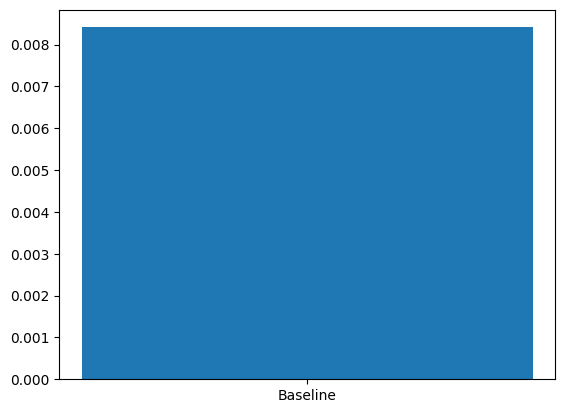

In [20]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=metrics)
baseline_result =baseline_result['accuracy']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

                                  precision    recall  f1-score   support

                         Correct       0.00      0.00      0.00       894
                   Contradictory       0.00      0.00      0.00       202
Partially correct but incomplete       0.00      0.00      0.00       516
                      Irrelevant       0.23      0.02      0.03       518
                      Non-domain       0.00      1.00      0.01         9

                        accuracy                           0.01      2139
                       macro avg       0.05      0.20      0.01      2139
                    weighted avg       0.06      0.01      0.01      2139



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


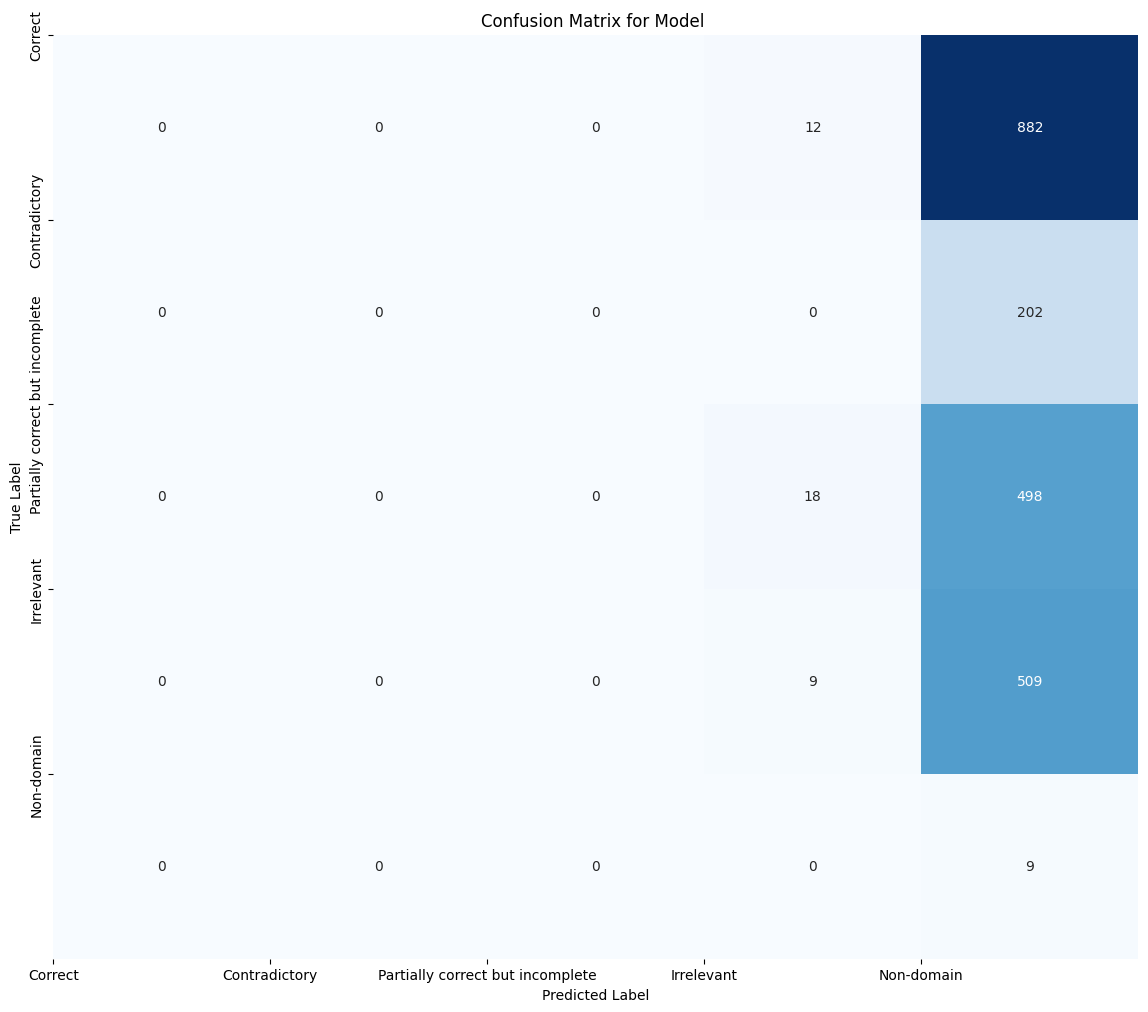

In [21]:
classlabel = ['Correct','Contradictory','Partially correct but incomplete','Irrelevant','Non-domain']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [22]:
from torch.optim import Optimizer

In [23]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # Define your loss function; Use CrossEntropyLoss
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    # TODO: Fill in the rest of the train function by applying the model with the dataloader
    # HINT: Remember to use .detach() before passing model predictions to update_metrics function,
    # and to send the model inputs .to() the device that the model is on
    for batch in train_dataloader:

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_function(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        predictions = torch.argmax(outputs.logits, dim=-1)
        update_metrics(metrics, predictions.detach(), batch['labels'])


    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    val_metrics,all_labels, all_predictions = evaluate(model, validation_dataloader, device, ['accuracy'])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")


In [25]:
from transformers import get_scheduler

num_epochs = 10

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer =  torch.optim.AdamW(model.parameters(), lr=2e-3)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [26]:
torch.cuda.empty_cache()
model.to(device)

# TODO: now call your training loop!
train(model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.36449586776859505
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.4148250460405157
Epoch 2 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.38981818181818184
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.4148250460405157
Epoch 3 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 3 average training metrics: accuracy=0.4066115702479339
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 validation: accuracy=0.4148250460405157
Epoch 4 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 4 average training metrics: accuracy=0.40826446280991735
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 validation: accuracy=0.4148250460405157
Epoch 5 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 5 average training metrics: accuracy=0.4107107438016529
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 validation: accuracy=0.4148250460405157
Epoch 6 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 6 average training metrics: accuracy=0.41137190082644626
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 validation: accuracy=0.4148250460405157
Epoch 7 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 7 average training metrics: accuracy=0.41137190082644626
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 validation: accuracy=0.4148250460405157
Epoch 8 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 8 average training metrics: accuracy=0.41137190082644626
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 validation: accuracy=0.4148250460405157
Epoch 9 training:


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 9 average training metrics: accuracy=0.41137190082644626
Running validation:


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 validation: accuracy=0.4148250460405157
Epoch 10 training:


  0%|          | 0/316 [00:00<?, ?it/s]

Epoch 10 average training metrics: accuracy=0.41137190082644626
Running validation:


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 validation: accuracy=0.4148250460405157


**Trained Model Metrics**

  0%|          | 0/45 [00:00<?, ?it/s]

Baseline accuracy: 0.008415147265077139
Trained accuracy: 0.4179523141654979


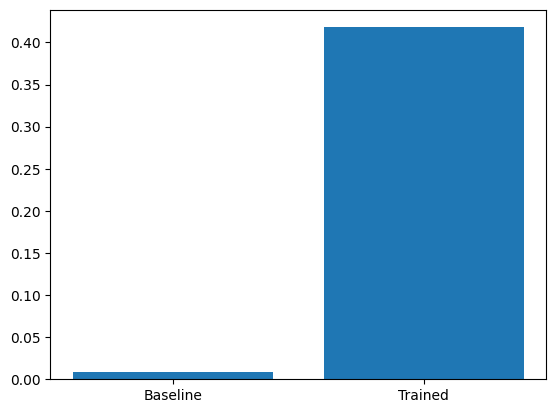

In [27]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=['accuracy'])

# now, plot! Do not modify the following:
results = baseline_result, trained_result['accuracy']
names = ['Baseline', 'Trained']
make_plots(results, names)

                                  precision    recall  f1-score   support

                         Correct       0.42      1.00      0.59       894
                   Contradictory       0.00      0.00      0.00       202
Partially correct but incomplete       0.00      0.00      0.00       516
                      Irrelevant       0.00      0.00      0.00       518
                      Non-domain       0.00      0.00      0.00         9

                        accuracy                           0.42      2139
                       macro avg       0.08      0.20      0.12      2139
                    weighted avg       0.17      0.42      0.25      2139



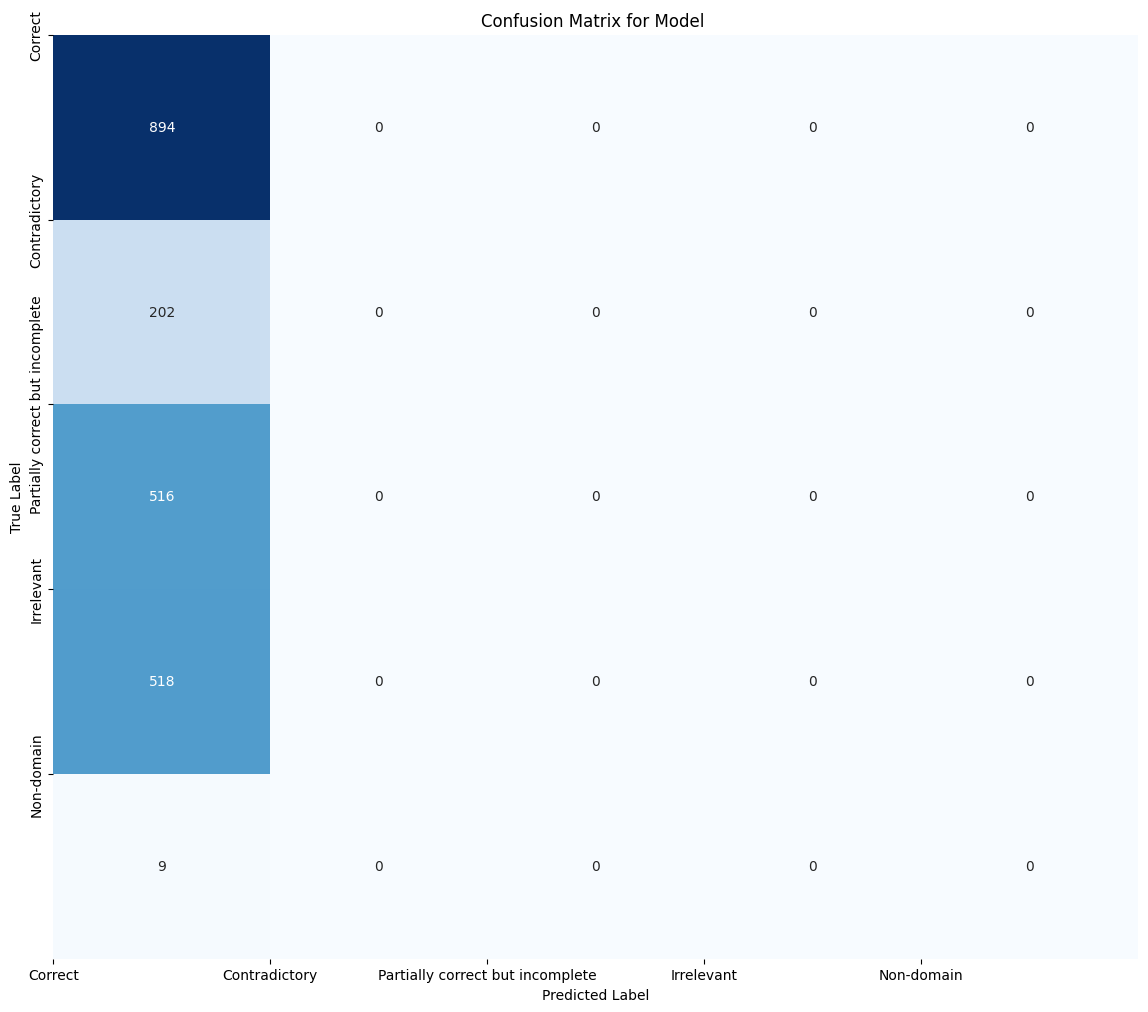

In [28]:
classlabel = ['Correct','Contradictory','Partially correct but incomplete','Irrelevant','Non-domain']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()